<center><h1>Heart Failure Detection</h1></center>

In [66]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import xgboost as xgb

%matplotlib inline
plt.rcParams.update({"font.size": 13, "figure.figsize": [8,4]})

# Load Dataset

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Here, the target variable is `DEATH_EVENT`. That means, it is a binary classification problem.

# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


From dataset description, we can see that:
- The shape of the dataset is (299, 13). 
- There is no missing value.
- The data type of `age` is float. We'll convert it to integer.

In [4]:
df["age"] = df["age"].astype(int)

In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.829431,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894997,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


From dataset description, we can see that:
- `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, `smoking` and `DEATH_EVENT` are qualitative variables. One easy way to find out is to check the min and max values of those variables. We need to decode these variables.
- The rest are quantitative variables.

Decode the qualitative variables:

In [6]:
binary_values = {
    0: True,
    1: False
}
df["diabetes"] = df["diabetes"].map(binary_values)
df["high_blood_pressure"] = df["high_blood_pressure"].map(binary_values)
df["smoking"] = df["smoking"].map(binary_values)
df["DEATH_EVENT"] = df["DEATH_EVENT"].map(binary_values)
df["anaemia"] = df["anaemia"].map(binary_values)

sex_values = {
    0: "female",
    1: "male"
}
df["sex"] = df["sex"].map(sex_values)

In [7]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,True,582,True,20,False,265000.00,1.9,130,male,True,4,False
1,55,True,7861,True,38,True,263358.03,1.1,136,male,True,6,False
2,65,True,146,True,20,True,162000.00,1.3,129,male,False,7,False
3,50,False,111,True,20,True,210000.00,1.9,137,male,True,7,False
4,65,False,160,False,20,True,327000.00,2.7,116,female,True,8,False


In [8]:
# sns.histplot(np.log1p(df["creatinine_phosphokinase"]), bins=30)
df["DEATH_EVENT"].value_counts()

True     203
False     96
Name: DEATH_EVENT, dtype: int64

In [9]:
# Split the data in train/val/test sets, with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["DEATH_EVENT"].values
y_val = df_val["DEATH_EVENT"].values
y_test = df_test["DEATH_EVENT"].values

# Delete target variable `price` from the dataframes
del df_train["DEATH_EVENT"]
del df_val["DEATH_EVENT"]
del df_test["DEATH_EVENT"]

In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [11]:
dv.get_feature_names_out()

array(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex=female', 'sex=male',
       'smoking', 'time'], dtype=object)

# Model Training

In this section, we are going to train three different classification models, tune hyperparameters and finally selecting the best model.

## 1.1 LogisticRegression Model

### 1.1.1 Base Model

In [44]:
# Train the model with training dataset
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [45]:
print(f"Model intercept: {lr.intercept_[0].round(5)}")
print(f"Model coefficients: {dict(zip(dv.get_feature_names_out(), lr.coef_[0].round(5)))}")

Model intercept: -0.00018
Model coefficients: {'age': -0.0479, 'anaemia': -0.00063, 'creatinine_phosphokinase': -0.00022, 'diabetes': -0.00027, 'ejection_fraction': 0.06368, 'high_blood_pressure': -0.00018, 'platelets': 0.0, 'serum_creatinine': -0.00833, 'serum_sodium': -0.00556, 'sex=female': 0.00079, 'sex=male': -0.00097, 'smoking': 9e-05, 'time': 0.01762}


In [46]:
# Predict using validation dataset
y_pred = lr.predict_proba(X_val)[:,1]
result = (y_pred >= 0.5)
print(f"Accuracy: {(y_val == result).mean().round(3)}")

Accuracy: 0.817


For classification tasks, we can not only rely on the accuracy of the model, specially when the dataset is imbalanced. In our dataset, we have more True outputs than False. So, we need to check other metrics as well depending on our problem.

### 1.1.2 Tune Hyperparameters using GridSearchCV

https://machinelearningknowledge.ai/hyperparameter-tuning-with-sklearn-gridsearchcv-and-randomizedsearchcv/

### 1.1.3 Tuned Model

### 1.1.4 Model Interpretation

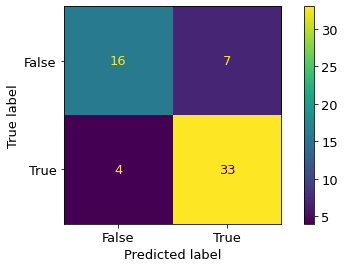

In [47]:
# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.show()

In our validation dataset, we have total 60 records where 23 records have False outcome and 37 records have True outcome. But our model predicted 20 False and 40 True outcomes. For our particular problem, the **False Negative** value is the most important metric. It means that the model predicted that the person will not die, but actually the person died. And we want to minimize this False Negative error.

For this, we need to find a threshold that has high **Recall** value. (Precision is not that important for our problem as it does not consider FN values.)

In [48]:
# Iterate over different threshold values and calculate recall
thresholds = np.arange(0, 1.01, 0.01)

scores = []
for t in thresholds:
    result = (y_pred >= t)
    fn = confusion_matrix(y_val, result)[1][0]
    recall = recall_score(y_val, result, zero_division=0).round(3)
    scores.append((t, fn, recall))

df_scores = pd.DataFrame(scores, columns=["threshold", "FN", "recall"])
df_scores

,threshold,FN,recall
0,0.00,0,1.000
1,0.01,0,1.000
2,0.02,0,1.000
3,0.03,0,1.000
4,0.04,0,1.000
...,...,...,...
96,0.96,36,0.027
97,0.97,36,0.027
98,0.98,37,0.000
99,0.99,37,0.000


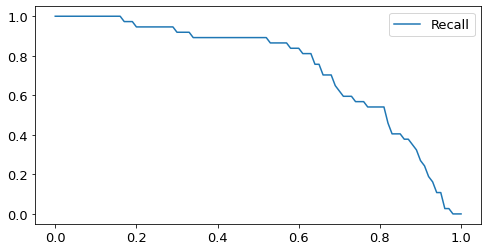

In [49]:
# Draw recall plot
plt.plot(df_scores["threshold"], df_scores['recall'], label='Recall')
plt.legend()
plt.draw()

From the plot, we can see that the recall value is maximum till threshold 0.2. Let's precisely find the threshold value where recall is maximum.

In [50]:
threshold = df_scores[df_scores["recall"] == 1]["threshold"].max()
print(f"Threshold: {threshold}")
df_scores[df_scores["threshold"] == 0.16]

Threshold: 0.16


,threshold,FN,recall
16,0.16,0,1.0


For threshold 0.16, we get FN = 0.

### 1.1.5 Final Model

Now again, let's train the model with threshold 0.16.

In [51]:
# Train the model with training dataset
lrr = LogisticRegression(random_state=1)
lrr.fit(X_train, y_train)

# Predict using validation dataset
y_pred = lrr.predict_proba(X_val)[:,1]
result = (y_pred >= 0.16)
print(f"Accuracy: {(y_val == result).mean().round(3)}")

Accuracy: 0.683


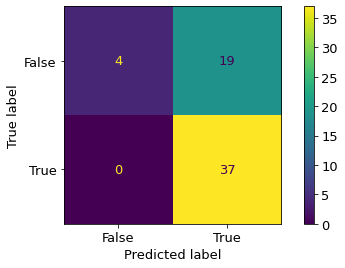

In [42]:
# Calculate the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, result)

We can see that the accuracy has decreased significantly from 0.817 to 0.683. But the model does not predict FN. Saving life is more important than False Positive. This is a trade-off that we have to keep in mind.

## 1.2 DecisionTreeClassifier Model

### 1.2.1 Base Model

In [20]:
# Train the model with training dataset using default parameters
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [21]:
# Predict using validation dataset
y_pred = dt.predict_proba(X_val)[:,1]
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.791


In [22]:
# Predict using training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred).round(3)}")

Training dataset AUC: 1.0


By comparing the AUC of training and validation dataset, we can see that our DecisionTreeClassifier model is overfitted for training datset as the AUC is 1.0. The reason is we trained the model with default parameters. Now let's try to improve the model by tuning these default parameters. For this, again we are going to use GridSearchCV.

### 1.2.2 GridSearchCV

In [23]:
# Define the parameter grid
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter":["best", "random"],
    "max_depth": [None, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_features":[None, 3, 5, 7, 9, 11],
    "min_samples_leaf": [2, 3, 5, 7, 9, 11],
    "min_samples_split": [2, 3, 5, 7, 9, 11, 13, 15]
}

In [24]:
# Define the grid search model
dt = DecisionTreeClassifier(random_state=1)
search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    n_jobs=-1
)
# By default it uses 5 fold

# Train the grid search model with training dataset
search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 3, 5, 7, 9, 11],
                         'min_samples_leaf': [2, 3, 5, 7, 9, 11],
                         'min_samples_split': [2, 3, 5, 7, 9, 11, 13, 15],
                         'splitter': ['best', 'random']})

In [25]:
# Get the tuned hyperparameters from the grid search model
print(f"Best parameter (CV Score = {search.best_score_.round(3)}):")
print(search.best_params_)

Best parameter (CV Score = 0.843):
{'criterion': 'gini', 'max_depth': 6, 'max_features': 9, 'min_samples_leaf': 3, 'min_samples_split': 13, 'splitter': 'random'}


### 1.1.3 Tuned Model

In [62]:
# Train the model again with tuned parameters
dt = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=6, 
    max_features=9, 
    min_samples_leaf=3, 
    min_samples_split=13, 
    splitter='random', 
    random_state=1
)
dt.fit(X_train, y_train)

# Predit using validation dataset
y_pred = dt.predict_proba(X_val)[:, 1]
print(f"Validation dataset AUC: {roc_auc_score(y_val, y_pred).round(3)}")

Validation dataset AUC: 0.858


In [57]:
# Predict using training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
print(f"Training dataset AUC: {roc_auc_score(y_train, y_pred).round(3)}")

Training dataset AUC: 0.909


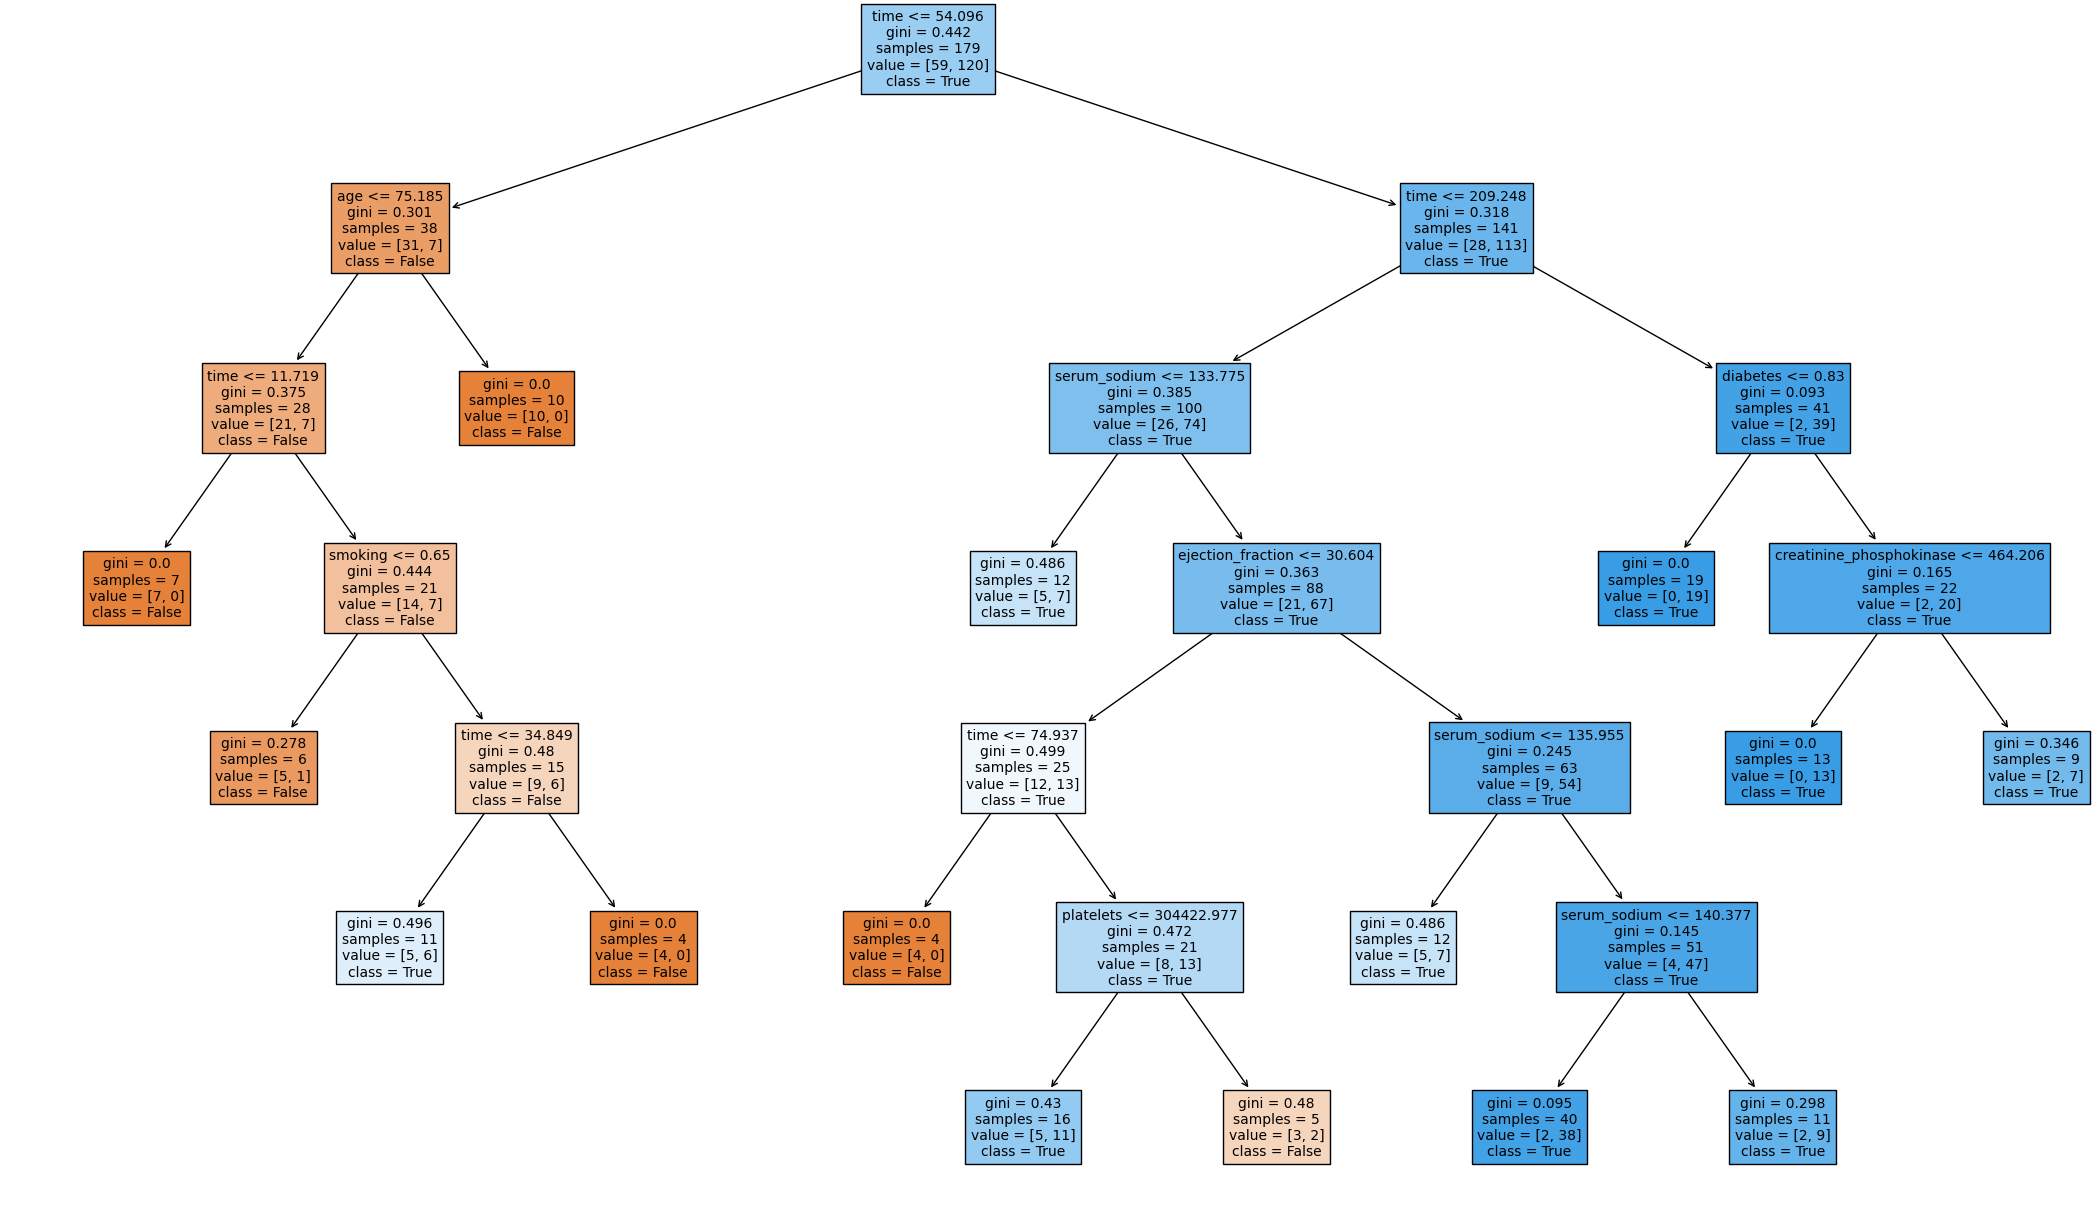

In [54]:
# Plot the decision tree
feature_names = list(dv.get_feature_names_out())
class_names = list(map(str, df["DEATH_EVENT"].unique()))

plt.figure(figsize=(20,12), dpi=100)
plot_tree(dt, feature_names=feature_names, class_names=class_names, filled=True, fontsize=10)
plt.show()
# Double click to zoom the plot

### 1.1.4 Result Interpretation

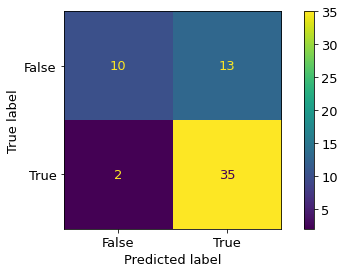

In [64]:
result = (y_pred >= 0.5)
ConfusionMatrixDisplay.from_predictions(y_val, result)
plt.show()

Interpretation of the result.

## Run RandomForestClassifier Model

In [30]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9300822561692127